In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D
from tqdm import tqdm
import time

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
# # 한글 폰트 적용 코드
# def fix_font():
#     # From https://HC.Dle.pw, By Jinseo Kim
#     # v1.0.0
#     import os
#     import matplotlib as mpl
#     import matplotlib.pyplot as plt
#     os.system("apt-get install -y fonts-nanum")
#     os.system("fc-cache -fv")
#     mpl.font_manager._rebuild()
#     findfont = mpl.font_manager.fontManager.findfont
#     mpl.font_manager.findfont = findfont
#     mpl.backends.backend_agg.findfont = findfont
#     plt.rcParams['font.family'] = "NanumBarunGothic"
#     plt.rcParams['axes.unicode_minus'] = False
           
# fix_font()

In [ ]:
data = pd.read_csv('./naver_story_002.csv')
data

In [ ]:
subset_df = data[['title', 'grade', 'story']]
# subset_df.head(20)

In [6]:
# # 레이블 분포 확인
# subset_df['grade'].value_counts().plot(kind='bar')

In [7]:
# subset_df['grade'].unique()

In [ ]:
subset_df.drop_duplicates(subset = ['story'], inplace=True) # 중복 제거
subset_df['story'] = subset_df['story'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
subset_df['story'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
subset_df = subset_df.dropna(how='any') # Null 값 제거

In [ ]:
# 맞춰야하는 grade를 y로 두고 labelencoding 하기
X = subset_df.drop(['grade'], axis=1)
y = subset_df['grade']
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
!pip install konlpy

from konlpy.tag import Mecab
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 78.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached lxml-4.9.1-cp38-cp38-macosx_11_0_arm64.whl
  Created wheel for JPype1: filename=JPype1-1.4.0-cp38-cp38-macosx_11_0_arm64.whl size=371940 sha256=d8cdda8f2c2aa394d48c16f27b8cd83349423d96542b47c11948f6ee777027fb
  Stored in directory: /Users/krc/Library/Caches/pip/wheels/9e/e1/26/00a64d833a6c69720288a0b0851e16f87e741ad8fb213f0b3a
Successfully built JPype1
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/Users/krc/year_dream/Project5/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab190912.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-08-25 14:

In [7]:
# Mecab을 이용한 토큰화
from konlpy.tag import Okt, Mecab

mecab = Mecab()
# okt = Okt()

# 불용어 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [9]:
# train data mecab을 통한 형태소 분석

train_X = []

for sentence in tqdm(X_train['story']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    train_X.append(stopwords_removed_sentence)

100%|███████████████████████████████████| 25253/25253 [00:06<00:00, 3926.74it/s]


In [10]:
# test data mecab을 통한 형태소 분석

test_X = []

for sentence in tqdm(X_test['story']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    test_X.append(stopwords_removed_sentence)

100%|█████████████████████████████████████| 6314/6314 [00:01<00:00, 4083.44it/s]


In [ ]:
# X_train = train_X
# X_test = test_X

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)

In [ ]:
# print(tokenizer.word_index)

In [ ]:
# threshold = 3
# total_cnt = len(tokenizer.word_index) # 단어의 수
# rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
# total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
# rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# for key, value in tokenizer.word_counts.items():
#     total_freq = total_freq + value

#     # 단어의 등장 빈도수가 threshold보다 작으면
#     if(value < threshold):
#         rare_cnt = rare_cnt + 1
#         rare_freq = rare_freq + value

# print('단어 집합(vocabulary)의 크기 :',total_cnt)
# print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
# print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
# print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# 임베딩 층 사용하여 단어 임베딩

In [11]:
X_train = train_X
X_test = test_X

# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = len(tokenizer.word_index) + 1
# print('단어 집합의 크기 :',vocab_size)

# text sequence to int sequence
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# # GloVe word embedding
# embeddings_dictionary = dict()
# glove = open('./glove.6B.100d.txt', encoding='utf8')

# for line in glove:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = np.asarray(records[1:], dtype='float32')
#     embeddings_dictionary[word] = vector_dimensions
    
# glove.close()

# embedding_matrix = np.zeros((vocab_size, 100))
# for word, index in tokenizer.word_index.items():
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector

In [ ]:
# # 토큰화
# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(X_train)

# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

# vocab_size = len(tokenizer.word_index) + 1

In [18]:
X_test = pad_sequences(X_test)
X_train = pad_sequences(X_train)

In [19]:
# build the neural network model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-08-05 14:18:51.750179: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         10174200  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 10,291,964
Trainable params: 117,764
Non-trainable params: 10,174,200
_________________________________________________________________


In [18]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
158/158 [==============================] - 3268s 21s/step - loss: 1.2811 - accuracy: 0.4019 - val_loss: 1.2644 - val_accuracy: 0.4346
Epoch 2/10
158/158 [==============================] - 3241s 21s/step - loss: 1.2540 - accuracy: 0.4227 - val_loss: 1.2371 - val_accuracy: 0.4399
Epoch 3/10
158/158 [==============================] - 5938s 38s/step - loss: 1.2327 - accuracy: 0.4359 - val_loss: 1.2252 - val_accuracy: 0.4407
Epoch 4/10
158/158 [==============================] - 11897s 75s/step - loss: 1.2234 - accuracy: 0.4363 - val_loss: 1.2186 - val_accuracy: 0.4373
Epoch 5/10
158/158 [==============================] - 11724s 74s/step - loss: 1.2125 - accuracy: 0.4431 - val_loss: 1.2093 - val_accuracy: 0.4435
Epoch 6/10
158/158 [==============================] - 11414s 72s/step - loss: 1.2089 - accuracy: 0.4410 - val_loss: 1.2092 - val_accuracy: 0.4474
Epoch 7/10
158/158 [==============================] - 11661s 74s/step - loss: 1.2017 - accuracy: 0.4519 - val_loss: 1.2020 - va

In [19]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

198/198 [==============================] - 225s 1s/step - loss: 1.1960 - accuracy: 0.4558
loss:  1.1960245370864868
accuracy:  0.4558124840259552


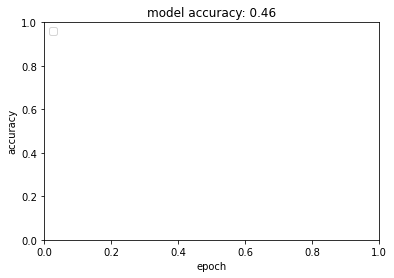

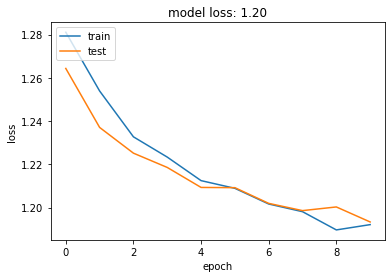

In [21]:
# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
plt.title('model accuracy: {:.2f}'.format(acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss: {:.2f}'.format(loss))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# save the model
model.save('movie_description_classifier_1.h5')

# save the tokenizer for use in other clients
pickle.dump(tokenizer, open('tokenizer2.pkl', 'wb'))

In [38]:
synopsis = """
'깊은 산속 드래곤캐슬에
 꼬마 드래곤 왕 아서의 막강한 힘이 봉인된 보석 ‘드래곤 하트’를 빼앗아
 왕이 되려는 수상한 마법사 게드가 나타난다.
 
 한편, 우연히 ‘드래곤 하트’의 힘을 흡수한 크롱이
 자이언트 크롱으로 변하면서 뽀로로와 친구들 역시 위험에 처한다.
 
 아서와 뽀로로와 친구들은
 악당 마법사 게드로부터 힘을 되찾고 친구들을 구하기 위해
 무적의 메카드래곤을 만들어 드래곤캐슬로 향하는데…!
 
 뽀로로와 친구들의 판타지 액션 어드벤처!
 과연 드래곤캐슬과 소중한 친구들을 지켜낼 수 있을까?'
 """

In [39]:
# dictionary of key-value mappings for MPAA ratings
mpaa_ratings = { 0:'전체관람가', 1:'12세 관람가', 2:'15세 관람가', 3:'청소년관람불가'}

saved_tokenizer = pickle.load(open('./tokenizer.pkl', 'rb'))
synopsis = saved_tokenizer.texts_to_sequences(synopsis)

flat_list = []
for sublist in synopsis:
    for item in sublist:
        flat_list.append(item)

synopsis = pad_sequences([flat_list])
# print(synopsis)
y_prob = model.predict(synopsis, verbose=0)
prediction = y_prob.argmax(axis=-1)
# print(prediction)
print('이 영화의 등급은 {} 입니다.'.format(mpaa_ratings[prediction[0]]))

이 영화의 등급은 12세 관람가 입니다.
